In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!tar -xzvf "/content/drive/MyDrive/dataset.tar.gz"

dataset/
dataset/images/
dataset/images/CHNCXR_0001_0.png
dataset/images/CHNCXR_0002_0.png
dataset/images/CHNCXR_0003_0.png
dataset/images/CHNCXR_0004_0.png
dataset/images/CHNCXR_0005_0.png
dataset/images/CHNCXR_0006_0.png
dataset/images/CHNCXR_0007_0.png
dataset/images/CHNCXR_0008_0.png
dataset/images/CHNCXR_0009_0.png
dataset/images/CHNCXR_0010_0.png
dataset/images/CHNCXR_0011_0.png
dataset/images/CHNCXR_0012_0.png
dataset/images/CHNCXR_0013_0.png
dataset/images/CHNCXR_0014_0.png
dataset/images/CHNCXR_0015_0.png
dataset/images/CHNCXR_0016_0.png
dataset/images/CHNCXR_0017_0.png
dataset/images/CHNCXR_0018_0.png
dataset/images/CHNCXR_0019_0.png
dataset/images/CHNCXR_0020_0.png
dataset/images/CHNCXR_0021_0.png
dataset/images/CHNCXR_0022_0.png
dataset/images/CHNCXR_0023_0.png
dataset/images/CHNCXR_0024_0.png
dataset/images/CHNCXR_0025_0.png
dataset/images/CHNCXR_0026_0.png
dataset/images/CHNCXR_0027_0.png
dataset/images/CHNCXR_0028_0.png
dataset/images/CHNCXR_0029_0.png
dataset/images/CHN

In [11]:
from keras.layers import Conv2D,BatchNormalization,Activation,MaxPool2D,Conv2DTranspose,Concatenate,Input
from keras.models import Model

In [12]:
def conv(input,no):
  layer=Conv2D(no,3,padding='same')(input)
  norm=BatchNormalization()(layer)
  act=Activation('relu')(norm)

  layer2=Conv2D(no,3,padding='same')(act)
  norm2=BatchNormalization()(layer2)
  act2=Activation('relu')(norm2)

  return act2
#conv block serves as a common block to both the upscaling and downscaling part the architecture

In [13]:
def down_scale(input,no):
  convolution_layer=conv(input,no)
  pooling=MaxPool2D(pool_size=(2,2))(convolution_layer)
  return convolution_layer,pooling   
 # we return both the conv output and the pooling output so that as to
# enable the skip connections and the proceed with the down scaling 


In [14]:
def up_scale(input,skip_connections,no):
  up_scaling=Conv2DTranspose(no,kernel_size=(2,2),strides=2,padding='same')(input)
# stride = 2 implies that the size of the image ie both the height and the weight of the image is doubled 
  conc=Concatenate()([up_scaling,skip_connections])
  convol=conv(conc,no)
  return convol


In [33]:
def UNET(input_img):
  inputs=Input(input_img)
  skip_conn1,down1=down_scale(inputs,64)
  skip_conn2,down2=down_scale(down1,128)
  skip_conn3,down3=down_scale(down2,256)
  skip_conn4,down4=down_scale(down3,256)
  skip_conn5,down5=down_scale(down4,512)
  skip_conn6,down6=down_scale(down5,512)
  skip_conn7,down7=down_scale(down6,512)
  skip_conn8,down8=down_scale(down7,512)
  bridge=conv(down8,1024)

  up1=up_scale(bridge,skip_conn8,512)
  up2=up_scale(up1,skip_conn7,512)
  up3=up_scale(up2,skip_conn6,512)
  up4=up_scale(up3,skip_conn5,512)
  up5=up_scale(up4,skip_conn4,256)
  up6=up_scale(up5,skip_conn3,256)
  up7=up_scale(up6,skip_conn2,128)
  up8=up_scale(up7,skip_conn1,64 )

  output_layer=Conv2D(1,1,padding='same',activation='sigmoid')(up8)
#only one filter is required as we are doing binary segmentation and activation layer is sigmoid 
#as our mask contains only pixel values between 0 and 1 
  return Model(inputs,output_layer,name="U-NET")


In [34]:
input_shape=(512, 512, 3)
model=UNET(input_shape)
model.summary()

Model: "U-NET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 512, 512, 64  256        ['conv2d_35[0][0]']              
 ormalization)                  )                                                             

In [35]:
# source : tensorflow documentation
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [36]:
import os
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.metrics import Recall,Precision
from tensorflow.keras.optimizers import Adam
import cv2
from keras.callbacks import EarlyStopping,ModelCheckpoint,CSVLogger,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [37]:
# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_generator = image_datagen.flow_from_directory(
    '/content/dataset/images',
    class_mode=None,
    seed=seed)
mask_generator = mask_datagen.flow_from_directory(
    '/content/dataset/masks',
    class_mode=None,
    seed=seed)
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [38]:
def data_set():
  images=sorted(glob(os.path.join("/content/dataset","images","*.png")))
  images=images[0:704]
  masks=sorted(glob(os.path.join("/content/dataset","masks","*.png")))
  train_X,test_X,train_y,test_Y=train_test_split(images,masks,test_size=0.2,random_state=42)
  train_X,val_X,train_y,val_y=train_test_split(train_X,train_y,test_size=0.2,random_state=42)
  return train_X,train_y,val_X,test_X,test_Y,val_y

In [39]:
train_X,train_y,val_X,test_X,test_Y,val_y=data_set()

In [40]:
len(val_y)

113

In [41]:
def read_image(path):
  img=cv2.imread(path,cv2.IMREAD_COLOR)
  img=cv2.resize(img,(512,512))
  img=img/255
  img=img.astype(np.float32)
  return img

In [42]:
def read_mask(path):
  mask=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
  mask=cv2.resize(mask,(512,512))
  mask=mask/np.max(mask)
  mask=mask>0.5 # converts the pixel values either to zero or one
  mask=mask.astype(np.float32)
  mask=np.expand_dims(mask,axis=-1) # expands one dim along the last ax
  return mask

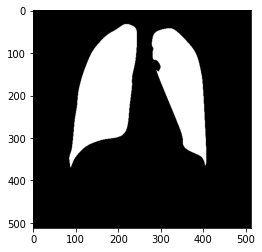

In [43]:
import matplotlib.pyplot as plt
plt.imshow(read_image(train_y[0]))

In [44]:
def tensor(path1,path2):
  def parse(path1,path2):
    path1=path1.decode()
    path2=path2.decode()
    img=read_image(path1)
    mask=read_mask(path2)
    return img,mask
  img,mask=tf.numpy_function(parse,[path1,path2],[tf.float32,tf.float32])
  img.set_shape([512,512,3])
  mask.set_shape([512,512,1])
  return img,mask

In [45]:
def dataset_tensor(X,Y):
  dataset=tf.data.Dataset.from_tensor_slices((X,Y))
  dataset=dataset.shuffle(buffer_size=200)
  dataset=dataset.map(tensor)
  dataset=dataset.batch(8)
  dataset=dataset.prefetch(4)
  return dataset

In [46]:
train_dataset=dataset_tensor(train_X,train_y)
val_dataset=dataset_tensor(val_X,val_y)
test_dataset=dataset_tensor(test_X,test_Y)

In [47]:
from keras import metrics
model.compile(loss=dice_loss,optimizer=Adam(1e-5),metrics=[dice_coef,iou,Recall(),Precision()])

In [50]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss',factor=0.2,min_lr=1e-7,verbose=1)]
model.load_weights("/content/first_attempt_w.h5")
# with tf.device("/gpu:0"):
#   history=model.fit(train_dataset,epochs=25,validation_data=val_dataset,callbacks=callbacks)

In [51]:
model.save_weights('first_attempt_w.h5')
model.save('first_attempt.h5')

EVALUTION PART

In [52]:
#SETTING THE SEEDING
from tqdm import tqdm
np.random.seed(42)
# tf.random.set_seed(42)
for x,y in tqdm(zip(test_X, test_Y), total=len(test_X)):
        """ Extracing the image name. """
        image_name = x.split("/")[-1]

        """ Reading the image """
        ori_x = cv2.imread(x, cv2.IMREAD_COLOR)
        ori_x = cv2.resize(ori_x, (512, 512))
        x = ori_x/255.0
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        ori_y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        ori_y = cv2.resize(ori_y, (512,512))
        ori_y = np.expand_dims(ori_y, axis=-1)  ## (512, 512, 1)
        ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)  ## (512, 512, 3)

        """ Predicting the mask. """
        y_pred = model.predict(x)[0] > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the predicted mask along with the image and GT """
        save_image_path = f"results/{image_name}"
        y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

        sep_line = np.ones((512, 10, 3)) * 255

        cat_image = np.concatenate([ori_x, sep_line, ori_y, sep_line, y_pred*255], axis=1)

        result_dir_path = f"results/{image_name}"
        
        def create_dir(path):
          if not os.path.exists(path):
            os.makedirs(path)
        create_dir("results")
        cv2.imwrite(result_dir_path, cat_image)


100%|██████████| 141/141 [00:42<00:00,  3.32it/s]
